# 1) Data cleaning

### Read files into dataframe

In [1]:
import pandas as pd 
import os
import glob

path = os.getcwd()
folder_name = "data" 
xlsx_files = glob.glob(os.path.join(path+"/"+folder_name, "*.xlsx"))

li = []
col_names = ['score', 'username', 'review_fr', 'company', 'product', 'type', 'date_publication', 'date_exp', 'review_en', 'review_corrected_fr', 'review_corrected_en']
for f in xlsx_files:
    df = pd.read_excel(f, index_col=None, header=0, names=col_names)
    li.append(df)

dataframe = pd.concat(li, axis=0, ignore_index=True)
dataframe.head()


,score,username,review_fr,company,product,type,date_publication,date_exp,review_en,review_corrected_fr,review_corrected_en
0,NaN,estelle-51227,j'ai quitté mon ancien contrat d'assurance che...,Néoliane Santé,sante,test,12/01/2017,01/01/2017,I left my former insurance contract at General...,NaN,NaN
1,NaN,leadum-51107,j'ai souscrit à cette mutuelle l'année dernier...,Néoliane Santé,sante,test,09/01/2017,01/01/2017,I subscribed to this mutual a year last year a...,NaN,NaN
2,NaN,enora-49520,"Impossible d'avoir le bon service , ils raccro...",Néoliane Santé,sante,test,24/11/2016,01/11/2016,"Impossible to have the right service, they han...",NaN,NaN
3,NaN,bea-139295,Génération est une mutuelle très chère pour un...,Génération,sante,test,09/11/2021,01/11/2021,Generation is a very expensive mutual for a re...,NaN,NaN
4,NaN,anna-139192,je viens d apprendre que je suis radié... j ap...,Génération,sante,test,08/11/2021,01/11/2021,I just learned that I am struck off ... I call...,NaN,NaN


### Data cleaning

In [2]:
# Show the number of missing values, and the total number of rows
print(dataframe.isna().sum())

total_rows = dataframe.shape[0]
print()
print(f"Total number of rows: {total_rows}")

score                  10331
username                   1
review_fr                  0
company                    0
product                    0
type                       0
date_publication           0
date_exp                   0
review_en                  2
review_corrected_fr    34000
review_corrected_en    34004
dtype: int64

Total number of rows: 34435


Translation

In [3]:
from googletrans import Translator

def translate_sentence(sentence, src_language='fr', dest_language='en'):
    translator = Translator()
    translation = translator.translate(sentence, src=src_language, dest=dest_language)
    return translation.text

# Fill empty entries in the 'review_en' column by translating 'review_fr'
df['review_en'] = df.apply(lambda row: translate_sentence(row['review_fr']) if pd.isna(row['review_en']) or row['review_en'] == '' else row['review_en'], axis=1)
print(dataframe.isna().sum())

score                  10331
username                   1
review_fr                  0
company                    0
product                    0
type                       0
date_publication           0
date_exp                   0
review_en                  2
review_corrected_fr    34000
review_corrected_en    34004
dtype: int64


Handling missing values

In [4]:
df = dataframe
# drop rows with an undefined value for the specified column
df.dropna(subset=['review_en'], inplace=True)

#remove columns not needed
df.drop(columns=['username', 'review_fr', 'company', 'product', 'date_publication', 'date_exp', 'review_corrected_fr', 'review_corrected_en'], inplace=True)

Lowercasing

In [5]:
def lowercase(frame, starting_column, final_column):
    frame[final_column] = frame[starting_column].map(lambda r: r.lower())

lowercase(df, 'review_en', 'review_cleaned')

Remove punctuation

In [6]:
def remove_punctuation(df, starting_column, final_column):
    df[final_column] = df[starting_column].str.replace('[^\w\s]','', regex=True)

remove_punctuation(df, 'review_cleaned', 'review_cleaned')

In [7]:
df.head()

,score,type,review_en,review_cleaned
0,NaN,test,I left my former insurance contract at General...,i left my former insurance contract at general...
1,NaN,test,I subscribed to this mutual a year last year a...,i subscribed to this mutual a year last year a...
2,NaN,test,"Impossible to have the right service, they han...",impossible to have the right service they hang...
3,NaN,test,Generation is a very expensive mutual for a re...,generation is a very expensive mutual for a re...
4,NaN,test,I just learned that I am struck off ... I call...,i just learned that i am struck off i call an...


Spelling correction

In [8]:
# # pip install textblob
# from textblob import TextBlob
# from tqdm import tqdm

# def correct_spelling(sentence):
#     blob = TextBlob(sentence)
#     return str(blob.correct())

# def correct_reviews_spelling(df, starting_column, final_column):
#     # Adding tqdm progress bar to map
#     tqdm.pandas()  # Initialize tqdm to work with pandas apply/map
#     df[final_column] = df[starting_column].progress_apply(lambda r: correct_spelling(r))

# correct_reviews_spelling(df, 'review_cleaned', 'review_cleaned')
# df.head()

Stopwords removal

In [9]:
from nltk.corpus import stopwords

def remove_stopwords(df, starting_column, final_column):
    stop = stopwords.words('english')
    df[final_column] = df[starting_column].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

remove_stopwords(df, 'review_cleaned', 'review_cleaned')

Tokenization

In [10]:
import nltk

def tokenize(df, starting_column, final_column):
    # Adds a column 'tokenized_rev' that contains for each entry a python list of words contained in the review
    df[final_column] = df.apply(lambda row: nltk.word_tokenize(row[starting_column]), axis=1)

tokenize(df, 'review_cleaned', 'review_cleaned')

Lemmatization

In [11]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('punkt')  # If working with tokenized data
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import wordnet

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default as noun

# Lemmatization function with POS tagging
def lemmatize_col(df, list_column_to_lemmatize, final_column):
    lmtzr = WordNetLemmatizer()
    # Tokenize and apply lemmatization with POS
    df[final_column] = df[list_column_to_lemmatize].apply(lambda lst: [lmtzr.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tag(lst)]
    )

lemmatize_col(df, 'review_cleaned', 'review_cleaned')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/Alberto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/Alberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Alberto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
df.head()

,score,type,review_en,review_cleaned
0,NaN,test,I left my former insurance contract at General...,"[leave, former, insurance, contract, general, ..."
1,NaN,test,I subscribed to this mutual a year last year a...,"[subscribe, mutual, year, last, year, stay, ye..."
2,NaN,test,"Impossible to have the right service, they han...","[impossible, right, service, hang, nose, know,..."
3,NaN,test,Generation is a very expensive mutual for a re...,"[generation, expensive, mutual, retiree, 150, ..."
4,NaN,test,I just learned that I am struck off ... I call...,"[learn, strike, call, adviser, give, answer, s..."


Handling Imbalanced Data

score
1.0    7271
4.0    4885
5.0    4849
2.0    3716
3.0    3382
Name: count, dtype: int64


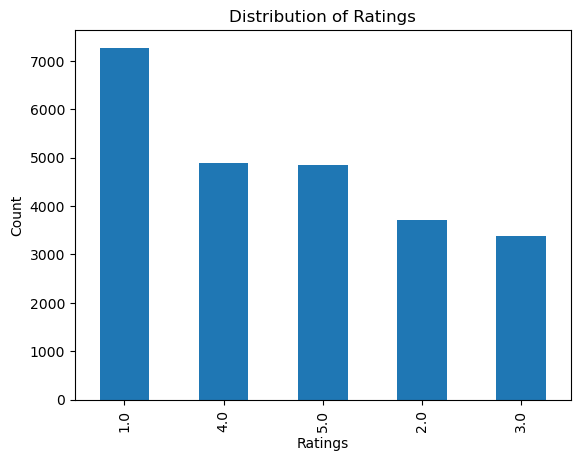

In [13]:
import matplotlib.pyplot as plt

# Check the distribution of labels
label_counts = df['score'].value_counts()
print(label_counts)

# Plot the distribution of labels
label_counts.plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

Highlighting frequent words

In [14]:
# Convert review_cleaned back to strings
df['review_cleaned_joined'] = df['review_cleaned'].apply(lambda x: ' '.join(x))

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer to count words
vectorizer = CountVectorizer()

# Fit and transform the text data into a word frequency matrix
X = vectorizer.fit_transform(df['review_cleaned_joined'])

# Get the frequency of each word
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))

# Sort by frequency
sorted_word_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))

# Display top 10 frequent words
print("Top 10 frequent words:", list(sorted_word_freq.items())[:10])

Top 10 frequent words: [('insurance', 18096), ('service', 11717), ('price', 11391), ('year', 9509), ('contract', 8857), ('take', 6839), ('customer', 6509), ('satisfied', 6256), ('month', 6084), ('make', 5899)]


N-grams

In [16]:
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt

# Function to extract n-grams from a list of words
def get_ngrams(text, n=2):
    words = text.split()
    return list(ngrams(words, n))

# Generate bigrams (2-word combinations)
bigrams = []
for review in df['review_cleaned_joined']:
    bigrams.extend(get_ngrams(review, n=2))

# Count bigram frequencies
bigram_freq = Counter(bigrams)

# Display top 10 frequent bigrams
print("Top 10 frequent bigrams:", bigram_freq.most_common(10))

Top 10 frequent bigrams: [(('customer', 'service'), 2422), (('satisfied', 'service'), 2323), (('direct', 'insurance'), 1824), (('take', 'care'), 1067), (('can', 'not'), 951), (('satisfied', 'price'), 881), (('take', 'account'), 813), (('service', 'price'), 774), (('2', 'month'), 733), (('insurance', 'company'), 714)]


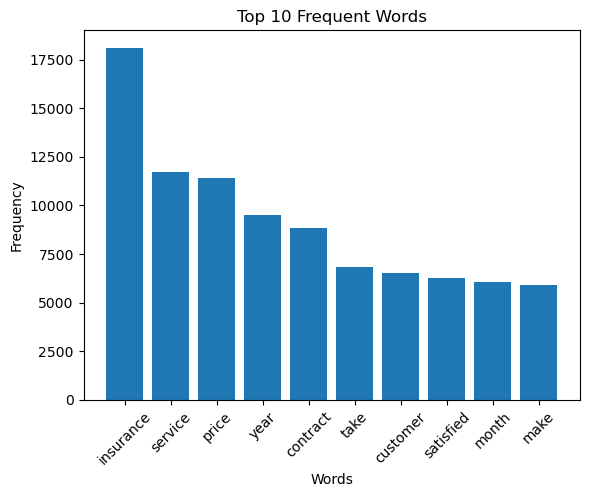

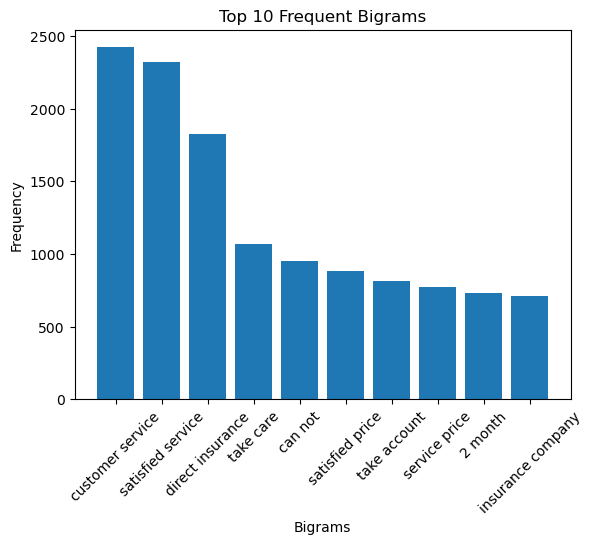

In [17]:
# Plotting the top 10 frequent words
top_words = list(sorted_word_freq.items())[:10]
words, counts = zip(*top_words)

plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Frequent Words')
plt.xticks(rotation=45)
plt.show()

# Plotting the top 10 frequent bigrams
top_bigrams = bigram_freq.most_common(10)
bigram_labels, bigram_counts = zip(*top_bigrams)

# Convert bigrams tuple to string format for plotting
bigram_labels = [' '.join(bigram) for bigram in bigram_labels]

plt.bar(bigram_labels, bigram_counts)
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.title('Top 10 Frequent Bigrams')
plt.xticks(rotation=45)
plt.show()

# 2) Summary, Translation, and Generation

In [18]:
# Save the results in a file
df.to_csv('data_cleaned.csv', index=False)

In [19]:
df.head()

,score,type,review_en,review_cleaned,review_cleaned_joined
0,NaN,test,I left my former insurance contract at General...,"[leave, former, insurance, contract, general, ...",leave former insurance contract general year j...
1,NaN,test,I subscribed to this mutual a year last year a...,"[subscribe, mutual, year, last, year, stay, ye...",subscribe mutual year last year stay year find...
2,NaN,test,"Impossible to have the right service, they han...","[impossible, right, service, hang, nose, know,...",impossible right service hang nose know answer...
3,NaN,test,Generation is a very expensive mutual for a re...,"[generation, expensive, mutual, retiree, 150, ...",generation expensive mutual retiree 150 per mo...
4,NaN,test,I just learned that I am struck off ... I call...,"[learn, strike, call, adviser, give, answer, s...",learn strike call adviser give answer sends nu...


# 3) Topic modeling and Lists of Topics

In [20]:
# Topic Modeling and Lists of Topics
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
 
# Ensure 'review_cleaned_joined' column is cleaned and ready
df['review_cleaned_joined'] = df['review_cleaned_joined'].fillna("").astype(str)
 
# Use CountVectorizer for LDA
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
 
doc_term_matrix = vectorizer.fit_transform(df['review_cleaned_joined'])
 
# Define the number of topics
n_topics = 5  # Change this value based on your preference
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(doc_term_matrix)
 
# Extract topics and top words
def get_topics(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
    return topics
 
n_top_words = 10  # Number of words per topic
feature_names = vectorizer.get_feature_names_out()
topics = get_topics(lda_model, feature_names, n_top_words)
 
# Print or save the topics
print("Extracted Topics:")
for topic in topics:
    print(topic)

Extracted Topics:
Topic 1: insurance, year, vehicle, car, expert, accident, claim, pay, home, damage
Topic 2: good, service, thank, satisfied, phone, advisor, telephone, recommend, listen, clear
Topic 3: month, mutual, service, time, file, insurance, wait, email, customer, phone
Topic 4: contract, insurance, year, pay, month, receive, make, send, increase, terminate
Topic 5: price, insurance, service, satisfied, recommend, good, simple, offer, direct, customer


# 4) Embedding to Identify Similar Words

Word2Vec Training

In [21]:
# pip install pandas gensim matplotlib scikit-learn

In [22]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Train a Word2Vec model
model = Word2Vec(sentences=df["review_cleaned"], vector_size=50, window=5, min_count=1, workers=1, sg=1)

# Save the trained model for future use
model.save("word2vec.model")


[nltk_data] Downloading package punkt to /Users/Alberto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Visualization of embeddings with Matplotlib and Tensorboard

Plotting words: 100%|██████████| 20/20 [00:00<00:00, 636.44it/s]


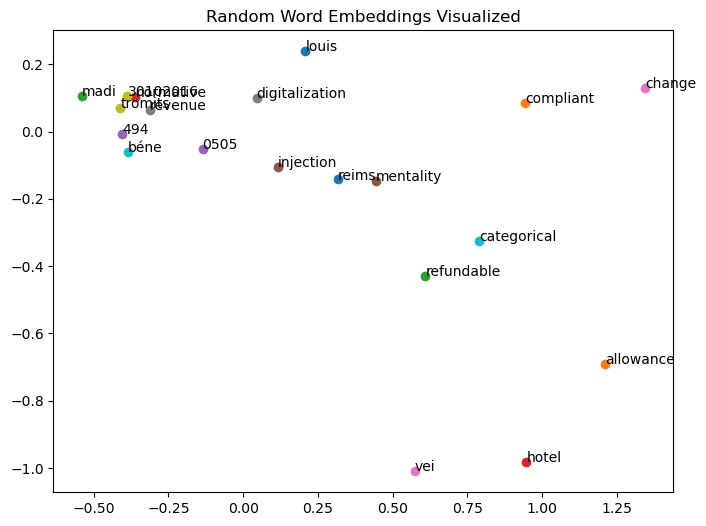

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Get word vectors
words = list(model.wv.index_to_key)
word_vectors = [model.wv[word] for word in words]

# Reduce dimensions to 2D
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

# Select some random words and their corresponding vectors
random_indices = random.sample(range(len(words)), 20)
random_words = [words[i] for i in random_indices]
random_word_vectors_2d = word_vectors_2d[random_indices]

# Plot only random word embeddings with tqdm progress bar
plt.figure(figsize=(8, 6))
for i, word in tqdm(enumerate(random_words), total=len(random_words), desc="Plotting words"):
    plt.scatter(random_word_vectors_2d[i, 0], random_word_vectors_2d[i, 1])
    plt.annotate(word, (random_word_vectors_2d[i, 0], random_word_vectors_2d[i, 1]))

plt.title("Random Word Embeddings Visualized")
plt.show()

Implementation of Euclidean or cosine distance

In [24]:
from scipy.spatial.distance import cosine

# Find similar words
def find_similar_words(word, top_n=3):
    similar_words = model.wv.most_similar(word, topn=top_n)
    return similar_words

# Example: Find similar words to "gas"
similar = find_similar_words("gas")
print("Words similar to 'gas':", similar)


Words similar to 'gas': [('tricolor', 0.975225567817688), ('perception', 0.9741259217262268), ('ibsi', 0.9741145372390747)]


Semantic search

In [25]:
import numpy as np

# Get sentence embeddings by averaging word embeddings
def get_sentence_embedding(sentence):
    words = word_tokenize(sentence)
    word_embeddings = [model.wv[word] for word in words if word in model.wv]
    if word_embeddings:
        return np.mean(word_embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Search for the most similar sentences
def semantic_search(query, df, top_n=3):
    query_embedding = get_sentence_embedding(query)
    df["similarity"] = df["review_cleaned_joined"].apply(
        lambda x: 1 - cosine(query_embedding, get_sentence_embedding(x))
    )
    return df.sort_values(by="similarity", ascending=False).head(top_n)

# Example: Search similar sentences to "Very satisfied with my mutual insurance"
query = "Very satisfied with my mutual insurance"
results = semantic_search(query, df)
print("Query:", query)
print("Most similar sentences:")
print(results[["review_cleaned_joined", "similarity"]])


/opt/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


Query: Very satisfied with my mutual insurance
Most similar sentences:
                                   review_cleaned_joined  similarity
5542   good insurance part happy mutual néoliane reas...    0.978881
2085                                    satisfied mutual    0.974397
30894  quick reimbursement advantageous price really ...    0.973999


In [26]:
df.drop(columns=['similarity'], inplace=True)

# 5.1) Rating Prediction application

    Model that, given a review, predicts number of stars

Purpose of TF-IDF: counting occurrencies of the words (word frequency)
Purpose of word embeddings: encode the semantic meaning of words

Example: “good” and “great” are unrelated in TF-IDF, but very close in word embeddings

We use word embeddings for deep learning models, and we use TF-IDF for simple classical ML models.
So now we don't use word embeddings

> TF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize and fit TF-IDF vectorizer
tfidf = TfidfVectorizer()  # Limit features to improve efficiency max_features=5000
tfidf_matrix = tfidf.fit_transform(df['review_cleaned_joined'])

In [28]:
df.head()

,score,type,review_en,review_cleaned,review_cleaned_joined
0,NaN,test,I left my former insurance contract at General...,"[leave, former, insurance, contract, general, ...",leave former insurance contract general year j...
1,NaN,test,I subscribed to this mutual a year last year a...,"[subscribe, mutual, year, last, year, stay, ye...",subscribe mutual year last year stay year find...
2,NaN,test,"Impossible to have the right service, they han...","[impossible, right, service, hang, nose, know,...",impossible right service hang nose know answer...
3,NaN,test,Generation is a very expensive mutual for a re...,"[generation, expensive, mutual, retiree, 150, ...",generation expensive mutual retiree 150 per mo...
4,NaN,test,I just learned that I am struck off ... I call...,"[learn, strike, call, adviser, give, answer, s...",learn strike call adviser give answer sends nu...


In [29]:
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.model_selection import train_test_split

# Drop rows where 'score' is NaN
df_new = df.dropna(subset=['score'])

# Generate the dataset using TF-IDF vectorizer
X = tfidf.fit_transform(df_new['review_cleaned_joined'])
y = df_new['score']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = log_reg.predict(X_test)

# Save the trained Logistic Regression model
joblib.dump(log_reg, './logistic_regression_model.pkl')

['./logistic_regression_model.pkl']

In [30]:
# EXAMPLE
# Sample review for prediction
sample_review = ["Very good"]

# Transform the sample review using the TF-IDF vectorizer
sample_review_tfidf = tfidf.transform(sample_review)

# Predict the rating using the trained logistic regression model
predicted_rating = log_reg.predict(sample_review_tfidf)

print(f"Predicted Rating: {predicted_rating[0]}")

Predicted Rating: 4.0


# 5.2) Sentiment analysis

In [31]:
df.head()

,score,type,review_en,review_cleaned,review_cleaned_joined
0,NaN,test,I left my former insurance contract at General...,"[leave, former, insurance, contract, general, ...",leave former insurance contract general year j...
1,NaN,test,I subscribed to this mutual a year last year a...,"[subscribe, mutual, year, last, year, stay, ye...",subscribe mutual year last year stay year find...
2,NaN,test,"Impossible to have the right service, they han...","[impossible, right, service, hang, nose, know,...",impossible right service hang nose know answer...
3,NaN,test,Generation is a very expensive mutual for a re...,"[generation, expensive, mutual, retiree, 150, ...",generation expensive mutual retiree 150 per mo...
4,NaN,test,I just learned that I am struck off ... I call...,"[learn, strike, call, adviser, give, answer, s...",learn strike call adviser give answer sends nu...


Zero-shot classification to label dataset

In [32]:
from transformers import pipeline
from tqdm import tqdm  # Progress bar library
import pandas as pd

# Initialize the pipeline
model_name = "distilbert-base-uncased"
classifier = pipeline("zero-shot-classification", model=model_name, device=0)  # Use GPU if available

# Load data
df = pd.DataFrame(df)
candidate_labels = ["positive", "neutral", "negative"]

# Batch processing with tqdm
batch_size = 16  # Adjust based on system capabilities
sentiments = []
for i in tqdm(range(0, len(df), batch_size), desc="Processing Batches", unit="batch"):
    batch_reviews = df['review_en'][i:i + batch_size].tolist()
    results = classifier(batch_reviews, candidate_labels=candidate_labels)
    sentiments.extend([result['labels'][0] for result in results])

df['sentiment'] = sentiments
print(df[['review_en', 'sentiment']])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
Processing Batches: 100%|██████████| 2153/2153 [4:48:14<00:00,  

                                               review_en sentiment
0      I left my former insurance contract at General...  negative
1      I subscribed to this mutual a year last year a...  negative
2      Impossible to have the right service, they han...  negative
3      Generation is a very expensive mutual for a re...  negative
4      I just learned that I am struck off ... I call...  negative
...                                                  ...       ...
34430     For the moment I am satisfied with this mutual  positive
34431  The service and support are of very good quali...  negative
34432  The worst insurance in which I was.\nDoubly of...  negative
34433  I am satisfied. The price suits me. Cheap. The...  negative
34434  Very well, good speed I highly recommend, effi...  positive

[34433 rows x 2 columns]


In [43]:
# Save the dataframe with sentiments to a CSV file
df.to_csv('sentiment_analysis_results.csv', index=False)

Supervised learning model

In [44]:
# Load the dataframe from a CSV file
df = pd.read_csv('sentiment_analysis_results.csv')

# Display the first few rows of the dataframe
df.head()

,score,type,review_en,review_cleaned,review_cleaned_joined,sentiment
0,NaN,test,I left my former insurance contract at General...,"['leave', 'former', 'insurance', 'contract', '...",leave former insurance contract general year j...,negative
1,NaN,test,I subscribed to this mutual a year last year a...,"['subscribe', 'mutual', 'year', 'last', 'year'...",subscribe mutual year last year stay year find...,negative
2,NaN,test,"Impossible to have the right service, they han...","['impossible', 'right', 'service', 'hang', 'no...",impossible right service hang nose know answer...,negative
3,NaN,test,Generation is a very expensive mutual for a re...,"['generation', 'expensive', 'mutual', 'retiree...",generation expensive mutual retiree 150 per mo...,negative
4,NaN,test,I just learned that I am struck off ... I call...,"['learn', 'strike', 'call', 'adviser', 'give',...",learn strike call adviser give answer sends nu...,negative


In [45]:
print(df.isna().sum())

df.dropna(subset=['review_cleaned_joined'], inplace=True)
print(df[df['review_cleaned_joined'].isna()])

score                    10327
type                         0
review_en                    0
review_cleaned               0
review_cleaned_joined        0
sentiment                    0
dtype: int64
Empty DataFrame
Columns: [score, type, review_en, review_cleaned, review_cleaned_joined, sentiment]
Index: []


Training the model

In [46]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard
import os

# Text Preprocessing (tokenization, padding)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['review_cleaned_joined'])

X = tokenizer.texts_to_sequences(df['review_cleaned_joined'])
X = pad_sequences(X, padding='post', maxlen=50)

# Convert sentiment to labels (binary or multiclass)
y = df['sentiment'].apply(lambda x: 0 if x == 'negative' else 1).values  # For binary classification

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=128, input_length=50, name='embedding'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # For binary classification, change for multiclass
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# TensorBoard setup
log_dir = os.path.join("logs", "embedding")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, embeddings_freq=1)

# Train model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[tensorboard_callback])

# Save the trained model for future use in a Streamlit app
model.save("sentiment_analysis_model.h5")

# Predict the sentiment on the validation set
y_val_pred = (model.predict(X_val) >= 0.5).astype(int)

# After training, start TensorBoard
# In your terminal (outside Jupyter Notebook):
# tensorboard --logdir=logs/embedding

Epoch 1/30


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8392 - loss: 0.4478 - val_accuracy: 0.8642 - val_loss: 0.3727
Epoch 2/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8725 - loss: 0.3485 - val_accuracy: 0.8556 - val_loss: 0.3854
Epoch 3/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8740 - loss: 0.3280 - val_accuracy: 0.8660 - val_loss: 0.3487
Epoch 4/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8768 - loss: 0.3053 - val_accuracy: 0.8661 - val_loss: 0.3487
Epoch 5/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8811 - loss: 0.2916 - val_accuracy: 0.8626 - val_loss: 0.3559
Epoch 6/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8848 - loss: 0.2856 - val_accuracy: 0.8617 - val_loss: 0.3611
Epoch 7/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8825 - loss: 0.2801 - val_accuracy: 0.8587 - val_loss: 0.3682
Epoch 8/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8858 - loss: 0.2762 - val_accuracy: 0.8565 - val_

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step


Example use

In [47]:
from tensorflow.keras.models import load_model

# Load the saved model (if needed in the future)
model_save_path = "sentiment_analysis_model.h5"
model = load_model(model_save_path)

# Define the tokenizer (this should be the same tokenizer used during training)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_new['review_cleaned_joined'])  # Ensure the tokenizer is fit on the same training data

# Function to predict sentiment for a randomly generated review
def predict_sentiment(review):
    # Text Preprocessing (tokenization and padding)
    review_sequence = tokenizer.texts_to_sequences([review])
    review_padded = pad_sequences(review_sequence, padding='post', maxlen=50)

    # Predict sentiment (0 for negative, 1 for positive)
    prediction = model.predict(review_padded)
    sentiment = "positive" if prediction >= 0.5 else "negative"
    return sentiment

# Example: Generate a random review and predict its sentiment
import random

# Generate a random review (You can replace this with any other method of generating a review)
random_reviews = [
    "The service was excellent, I am very satisfied!",
    "The product broke after a few days, very disappointed.",
    "Not bad, but could use some improvements.",
    "I love this! Will definitely buy again.",
    "Worst purchase ever. Terrible quality."
]

# Select a random review
random_review = random.choice(random_reviews)

# Print the review and its predicted sentiment
print(f"Review: {random_review}")
print(f"Predicted Sentiment: {predict_sentiment(random_review)}")

Review: Worst purchase ever. Terrible quality.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Sentiment: negative


# 6) Results Interpretation

1. Rating prediction model

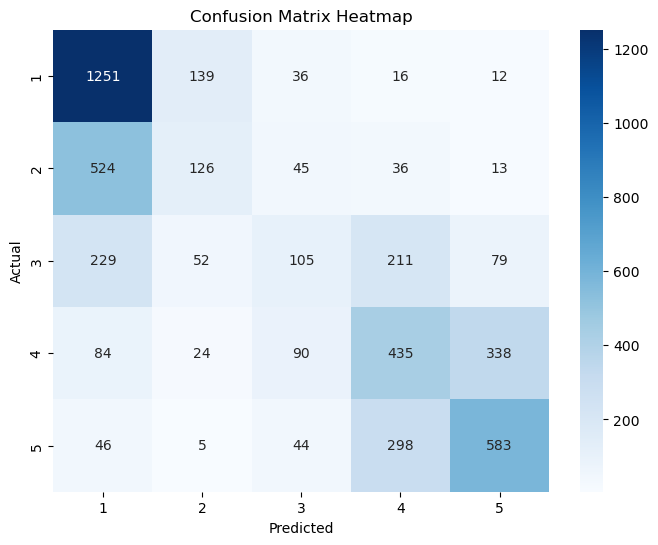

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['1', '2', '3', '4', '5'], yticklabels=['1', '2', '3', '4', '5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [49]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=['1', '2', '3', '4', '5'])
print(report)

              precision    recall  f1-score   support

           1       0.59      0.86      0.70      1454
           2       0.36      0.17      0.23       744
           3       0.33      0.16      0.21       676
           4       0.44      0.45      0.44       971
           5       0.57      0.60      0.58       976

    accuracy                           0.52      4821
   macro avg       0.46      0.45      0.43      4821
weighted avg       0.48      0.52      0.48      4821



2. Sentiment analysis model

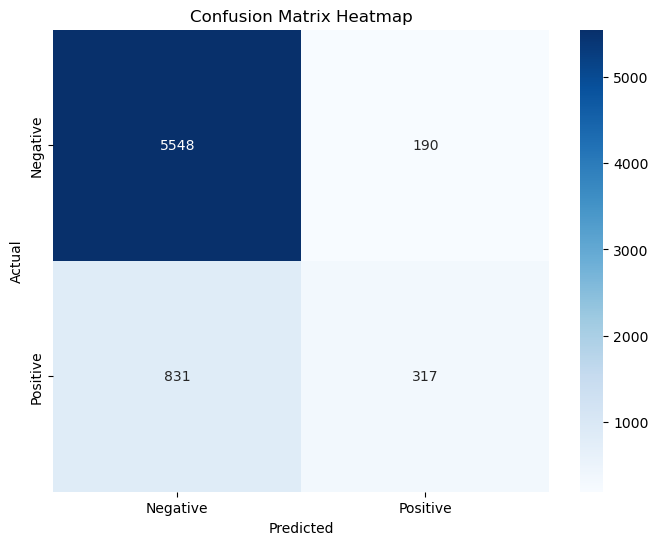

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [51]:
from sklearn.metrics import classification_report


# Generate the classification report
report = classification_report(y_val, y_val_pred, target_names=['negative', 'positive'])
print(report)

              precision    recall  f1-score   support

    negative       0.87      0.97      0.92      5738
    positive       0.63      0.28      0.38      1148

    accuracy                           0.85      6886
   macro avg       0.75      0.62      0.65      6886
weighted avg       0.83      0.85      0.83      6886



sentiment
negative    28830
positive     4956
neutral       643
Name: count, dtype: int64


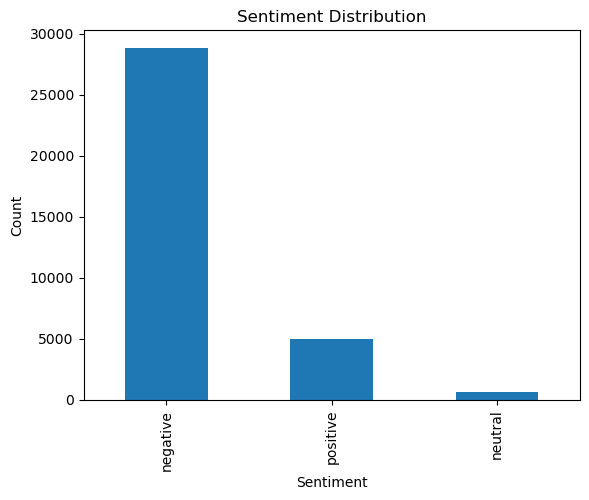

In [52]:
import matplotlib.pyplot as plt

# Count the sentiments
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

# Plot the sentiment distribution
sentiment_counts.plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()